In [1]:
import numpy as np
import keras
import tensorflow
from keras import layers
from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
import os

logdir = os.path.join("callbacks")

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# load dataset
dataset = pd.read_csv('line_1656.csv', header=0, index_col=0)
dataset = dataset.loc[:, ['Power', 'holidays', 'Hour', 'Days', 'Month', 'Temperature', 'humiduity', 'Wind_speed']]
#dataset['Power'] = dataset['Power'].apply(lambda x: x*100)
print(dataset.head())
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled = scaler.fit_transform(values)
print(scaled)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 529 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

   Power  holidays  Hour  Days  Month  Temperature  humiduity  Wind_speed
0  0.250         0   0.0    14      7         11.8       93.0        14.4
1  0.343         0   0.5    14      7         11.8       91.0        14.4
2  0.214         0   1.0    14      7         11.8       89.0        18.0
3  0.309         0   1.5    14      7         11.6       91.0        18.0
4  0.251         0   2.0    14      7         11.4       93.0        10.8
[[0.02445945 0.         0.         ... 0.6734694  0.93       0.16666666]
 [0.03355836 0.         0.0212766  ... 0.6734694  0.90999997 0.16666666]
 [0.02093729 0.         0.04255319 ... 0.6734694  0.89       0.22222221]
 ...
 [0.06985618 1.         0.95744675 ... 0.4927114  0.84999996 0.1111111 ]
 [0.05527835 1.         0.97872335 ... 0.4927114  0.84       0.1111111 ]
 [0.06496429 1.         0.99999994 ... 0.4927114  0.84       0.1111111 ]]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024459        0.0   0.000000   0.43

In [3]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=1e-1, input_shape=(train_X.shape[1], train_X.shape[2])):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv1D(filters = 48, kernel_size = 4, padding='same', 
                            activation='relu', kernel_initializer ="glorot_uniform"))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(filters = 32, kernel_size = 4, padding='same', 
                            activation='relu', kernel_initializer="glorot_uniform"))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(filters = 16, kernel_size = 4, padding ='same', 
                            activation='relu', kernel_initializer="glorot_uniform"))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Dropout(0.3))
    for layer in range(n_hidden):
        model.add(layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
    #model.add(layers.Dropout(0.5))
    #model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mape'])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs= {
    "n_hidden": np.arange(1, 10).tolist(),
    "n_neurons": np.arange(1, 300).tolist(),
    "learning_rate": [3e-2, 3e-3, 3e-4, 3e-5],
}

checkpoint_cb = keras.callbacks.ModelCheckpoint('load_forecasting_New_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(train_X, train_y, epochs=100, validation_split=0.3, shuffle=False, batch_size=32,
                  callbacks=[checkpoint_cb, early_stopping_cb])


print(rnd_search_cv.best_params_)
print('score:', rnd_search_cv.best_score_)

Epoch 1/100
445/445 [==============================] - 5s 9ms/step - loss: 0.0152 - mape: 66138.1399 - val_loss: 0.0059 - val_mape: 72.3582
Epoch 2/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0100 - mape: 225233.1324 - val_loss: 0.0058 - val_mape: 78.0917
Epoch 3/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0100 - mape: 228053.3214 - val_loss: 0.0058 - val_mape: 77.9077
Epoch 4/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0100 - mape: 226632.3831 - val_loss: 0.0058 - val_mape: 77.4070
Epoch 5/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0099 - mape: 226527.5122 - val_loss: 0.0058 - val_mape: 77.4170
Epoch 6/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0099 - mape: 230511.0223 - val_loss: 0.0057 - val_mape: 76.6666
Epoch 7/100
445/445 [==============================] - 3s 8ms/step - loss: 0.0098 - mape: 228288.1852 - val_loss: 0.0057 - val_mape: 75.6730
Epoch 8/100
44

Epoch 59/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0068 - mape: 145775.6740 - val_loss: 0.0045 - val_mape: 53.4404
Epoch 60/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0068 - mape: 151712.7193 - val_loss: 0.0045 - val_mape: 54.1748
Epoch 61/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0068 - mape: 149736.5504 - val_loss: 0.0045 - val_mape: 52.8477
Epoch 62/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0067 - mape: 151766.2849 - val_loss: 0.0045 - val_mape: 53.1596
Epoch 63/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0068 - mape: 151617.5767 - val_loss: 0.0045 - val_mape: 53.1030
Epoch 64/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0068 - mape: 140984.5431 - val_loss: 0.0045 - val_mape: 52.7787
Epoch 65/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0068 - mape: 148520.2236 - val_loss: 0.0045 - val_mape: 51.6314
Epoch 

445/445 [==============================] - 3s 7ms/step - loss: 0.0106 - mape: 36091.7944 - val_loss: 0.0057 - val_mape: 84.0382
Epoch 4/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0105 - mape: 36893.8688 - val_loss: 0.0057 - val_mape: 83.3350
Epoch 5/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0105 - mape: 38290.8988 - val_loss: 0.0056 - val_mape: 81.3725
Epoch 6/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0104 - mape: 39019.7511 - val_loss: 0.0056 - val_mape: 78.8270
Epoch 7/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0102 - mape: 38899.4955 - val_loss: 0.0055 - val_mape: 73.7551
Epoch 8/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0099 - mape: 39046.8530 - val_loss: 0.0054 - val_mape: 68.0948
Epoch 9/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0097 - mape: 35766.7889 - val_loss: 0.0053 - val_mape: 63.4737
Epoch 10/100
445/445 [==========

445/445 [==============================] - 3s 7ms/step - loss: 0.0088 - mape: 59255.1032 - val_loss: 0.0055 - val_mape: 7631.8076
Epoch 21/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0087 - mape: 54174.8455 - val_loss: 0.0055 - val_mape: 7502.3696
Epoch 22/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0086 - mape: 53861.1787 - val_loss: 0.0054 - val_mape: 7320.6489
Epoch 23/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0086 - mape: 50907.8220 - val_loss: 0.0054 - val_mape: 7225.0854
Epoch 24/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0086 - mape: 47040.7158 - val_loss: 0.0054 - val_mape: 7108.7891
Epoch 25/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0085 - mape: 52555.7989 - val_loss: 0.0054 - val_mape: 6974.2520
Epoch 26/100
445/445 [==============================] - 3s 7ms/step - loss: 0.0085 - mape: 53249.0386 - val_loss: 0.0053 - val_mape: 7029.1157
Epoch 27/100

Epoch 3/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0108 - mape: 34324.5301 - val_loss: 0.0058 - val_mape: 80.5329
Epoch 4/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0107 - mape: 34364.5895 - val_loss: 0.0058 - val_mape: 82.1233
Epoch 5/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0107 - mape: 34493.1379 - val_loss: 0.0058 - val_mape: 82.9731
Epoch 6/100
445/445 [==============================] - 2s 3ms/step - loss: 0.0107 - mape: 34584.7553 - val_loss: 0.0058 - val_mape: 83.2795
Epoch 7/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0107 - mape: 34622.0320 - val_loss: 0.0058 - val_mape: 83.3403
Epoch 8/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0107 - mape: 34630.1504 - val_loss: 0.0058 - val_mape: 83.3303
Epoch 9/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0107 - mape: 34629.6643 - val_loss: 0.0058 - val_mape: 83.3236
Epoch 10/100
445/445

Epoch 59/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0108 - mape: 62319.7411 - val_loss: 0.0062 - val_mape: 118.7448
Epoch 60/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 62354.3089 - val_loss: 0.0062 - val_mape: 118.6938
Epoch 61/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 62388.1913 - val_loss: 0.0062 - val_mape: 118.6448
Epoch 62/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 62421.4631 - val_loss: 0.0062 - val_mape: 118.5973
Epoch 63/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0108 - mape: 62454.3676 - val_loss: 0.0062 - val_mape: 118.5509
Epoch 64/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0108 - mape: 62487.1455 - val_loss: 0.0062 - val_mape: 118.5059
Epoch 65/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 62519.9221 - val_loss: 0.0062 - val_mape: 118.4624
Epo

Epoch 16/100
445/445 [==============================] - 4s 10ms/step - loss: 0.0108 - mape: 60718.3646 - val_loss: 0.0065 - val_mape: 14442.5361
Epoch 17/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 60804.9815 - val_loss: 0.0064 - val_mape: 14420.6143
Epoch 18/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 60842.1704 - val_loss: 0.0064 - val_mape: 14405.8867
Epoch 19/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 60765.0837 - val_loss: 0.0064 - val_mape: 14413.9434
Epoch 20/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 61009.5688 - val_loss: 0.0064 - val_mape: 14372.4258
Epoch 21/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 61113.1841 - val_loss: 0.0064 - val_mape: 14349.8760
Epoch 22/100
445/445 [==============================] - 4s 9ms/step - loss: 0.0108 - mape: 61205.9346 - val_loss: 0.0064 - val_mape: 14

Epoch 7/100
445/445 [==============================] - 3s 8ms/step - loss: 0.0107 - mape: 34630.2870 - val_loss: 0.0058 - val_mape: 83.3344
Epoch 8/100
445/445 [==============================] - 3s 8ms/step - loss: 0.0107 - mape: 34629.7459 - val_loss: 0.0058 - val_mape: 83.3261
Epoch 9/100
159/159 [==============================] - 0s 2ms/step - loss: 0.0076 - mape: 484992.3125
Epoch 1/100
445/445 [==============================] - 5s 8ms/step - loss: 0.0110 - mape: 57626.9052 - val_loss: 0.0064 - val_mape: 131.3878
Epoch 2/100
445/445 [==============================] - 3s 8ms/step - loss: 0.0108 - mape: 56416.8275 - val_loss: 0.0063 - val_mape: 124.2503
Epoch 3/100
445/445 [==============================] - 3s 8ms/step - loss: 0.0108 - mape: 56730.7012 - val_loss: 0.0063 - val_mape: 126.5196
Epoch 4/100
445/445 [==============================] - 3s 8ms/step - loss: 0.0108 - mape: 56983.4813 - val_loss: 0.0063 - val_mape: 126.8354
Epoch 5/100
445/445 [==============================] -

Epoch 40/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0074 - mape: 201502.3290 - val_loss: 0.0047 - val_mape: 68.4936
Epoch 41/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0073 - mape: 183525.5946 - val_loss: 0.0047 - val_mape: 68.4147
Epoch 42/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0074 - mape: 189377.1724 - val_loss: 0.0047 - val_mape: 67.7649
Epoch 43/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0073 - mape: 186195.0161 - val_loss: 0.0047 - val_mape: 67.8293
Epoch 44/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0072 - mape: 189276.4455 - val_loss: 0.0047 - val_mape: 66.3763
Epoch 45/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0072 - mape: 183018.3835 - val_loss: 0.0047 - val_mape: 67.1019
Epoch 46/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0072 - mape: 191617.1649 - val_loss: 0.0046 - val_mape: 64.9768
Epoch 

Epoch 98/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0067 - mape: 133734.7316 - val_loss: 0.0044 - val_mape: 48.2387
Epoch 99/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0067 - mape: 135696.1235 - val_loss: 0.0044 - val_mape: 47.9713
Epoch 100/100
159/159 [==============================] - 0s 1ms/step - loss: 0.0090 - mape: 60.8667
Epoch 1/100
445/445 [==============================] - 5s 5ms/step - loss: 0.0146 - mape: 28172.5529 - val_loss: 0.0072 - val_mape: 39.5625
Epoch 2/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0111 - mape: 88152.1177 - val_loss: 0.0059 - val_mape: 71.8418
Epoch 3/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0099 - mape: 122224.1931 - val_loss: 0.0058 - val_mape: 85.6707
Epoch 4/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0098 - mape: 126755.5000 - val_loss: 0.0058 - val_mape: 87.2674
Epoch 5/100
445/445 [==============================] -

445/445 [==============================] - 2s 5ms/step - loss: 0.0083 - mape: 216605.5423 - val_loss: 0.0051 - val_mape: 67.9083
Epoch 13/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0082 - mape: 223438.9904 - val_loss: 0.0050 - val_mape: 67.1505
Epoch 14/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0081 - mape: 220350.9820 - val_loss: 0.0049 - val_mape: 65.6716
Epoch 15/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0079 - mape: 221365.3884 - val_loss: 0.0049 - val_mape: 65.5537
Epoch 16/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0078 - mape: 221507.7119 - val_loss: 0.0048 - val_mape: 64.7477
Epoch 17/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0076 - mape: 212451.1533 - val_loss: 0.0048 - val_mape: 64.8494
Epoch 18/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0075 - mape: 205859.3025 - val_loss: 0.0047 - val_mape: 63.0565
Epoch 19/100
445/44

445/445 [==============================] - 2s 5ms/step - loss: 0.0086 - mape: 37231.8409 - val_loss: 0.0047 - val_mape: 58.8734
Epoch 23/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0086 - mape: 36174.9408 - val_loss: 0.0047 - val_mape: 58.9043
Epoch 24/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0086 - mape: 36337.4162 - val_loss: 0.0047 - val_mape: 60.7508
Epoch 25/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0086 - mape: 33349.6987 - val_loss: 0.0047 - val_mape: 58.6859
Epoch 26/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0085 - mape: 32169.2558 - val_loss: 0.0047 - val_mape: 58.7180
Epoch 27/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0084 - mape: 36291.1703 - val_loss: 0.0047 - val_mape: 59.2644
Epoch 28/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0084 - mape: 33919.6142 - val_loss: 0.0046 - val_mape: 58.2939
Epoch 29/100
445/445 [====

Epoch 2/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0108 - mape: 66102.0685 - val_loss: 0.0063 - val_mape: 13770.6719
Epoch 3/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0107 - mape: 65817.6168 - val_loss: 0.0063 - val_mape: 13569.4990
Epoch 4/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0106 - mape: 65838.6756 - val_loss: 0.0062 - val_mape: 13067.2686
Epoch 5/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0105 - mape: 66171.8281 - val_loss: 0.0062 - val_mape: 12435.3018
Epoch 6/100
159/159 [==============================] - 0s 1ms/step - loss: 0.0057 - mape: 81.4450
Epoch 1/100
445/445 [==============================] - 5s 6ms/step - loss: 0.0116 - mape: 166335.0921 - val_loss: 0.0058 - val_mape: 81.3837
Epoch 2/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0099 - mape: 213813.9093 - val_loss: 0.0057 - val_mape: 80.4929
Epoch 3/100
445/445 [===========================

445/445 [==============================] - 2s 3ms/step - loss: 0.0068 - mape: 149163.2796 - val_loss: 0.0047 - val_mape: 49.9114
Epoch 20/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0070 - mape: 150070.7514 - val_loss: 0.0046 - val_mape: 53.3614
Epoch 21/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0069 - mape: 149670.5392 - val_loss: 0.0046 - val_mape: 62.9077
Epoch 22/100
159/159 [==============================] - 0s 1ms/step - loss: 0.0093 - mape: 72.8636
Epoch 1/100
445/445 [==============================] - 3s 4ms/step - loss: 0.0101 - mape: 118481.6396 - val_loss: 0.0052 - val_mape: 71.0044
Epoch 2/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0083 - mape: 85720.6132 - val_loss: 0.0048 - val_mape: 64.4352
Epoch 3/100
445/445 [==============================] - 2s 4ms/step - loss: 0.0078 - mape: 56787.3972 - val_loss: 0.0048 - val_mape: 57.4198
Epoch 4/100
445/445 [==============================] - 2s 4ms/step 

Epoch 11/100
159/159 [==============================] - 0s 2ms/step - loss: 0.0115 - mape: 105649.2969
Epoch 1/100
445/445 [==============================] - 6s 6ms/step - loss: 0.0110 - mape: 34913.6896 - val_loss: 0.0058 - val_mape: 78.2539
Epoch 2/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0108 - mape: 34432.9544 - val_loss: 0.0058 - val_mape: 79.7459
Epoch 3/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0108 - mape: 34317.1757 - val_loss: 0.0058 - val_mape: 81.8169
Epoch 4/100
445/445 [==============================] - 3s 6ms/step - loss: 0.0107 - mape: 34454.0040 - val_loss: 0.0058 - val_mape: 82.9161
Epoch 5/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0107 - mape: 34573.5652 - val_loss: 0.0058 - val_mape: 83.2660
Epoch 6/100
445/445 [==============================] - 2s 5ms/step - loss: 0.0107 - mape: 34618.3768 - val_loss: 0.0058 - val_mape: 83.3407
Epoch 7/100
445/445 [==============================] - 2s

445/445 [==============================] - 1s 3ms/step - loss: 0.0077 - mape: 70214.6662 - val_loss: 0.0046 - val_mape: 52.9074
Epoch 36/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0078 - mape: 72410.5836 - val_loss: 0.0046 - val_mape: 51.1218
Epoch 37/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0078 - mape: 72909.7517 - val_loss: 0.0046 - val_mape: 51.5934
Epoch 38/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0078 - mape: 72207.1972 - val_loss: 0.0046 - val_mape: 51.3937
Epoch 39/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0077 - mape: 70128.0510 - val_loss: 0.0046 - val_mape: 51.3913
Epoch 40/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0077 - mape: 78186.3386 - val_loss: 0.0046 - val_mape: 51.3848
Epoch 41/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0077 - mape: 78304.0509 - val_loss: 0.0046 - val_mape: 51.1553
Epoch 42/100
445/445 [====

445/445 [==============================] - 1s 3ms/step - loss: 0.0081 - mape: 26576.1157 - val_loss: 0.0045 - val_mape: 53.5484
Epoch 63/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0081 - mape: 29462.6580 - val_loss: 0.0045 - val_mape: 52.6400
Epoch 64/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0080 - mape: 28326.2174 - val_loss: 0.0045 - val_mape: 51.8500
Epoch 65/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0081 - mape: 28835.7411 - val_loss: 0.0045 - val_mape: 53.0983
Epoch 66/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0081 - mape: 29109.9511 - val_loss: 0.0045 - val_mape: 51.6342
Epoch 67/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0080 - mape: 29417.7872 - val_loss: 0.0045 - val_mape: 52.9833
Epoch 68/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0080 - mape: 27918.3958 - val_loss: 0.0045 - val_mape: 51.2591
Epoch 69/100
445/445 [====

556/556 [==============================] - 1s 3ms/step - loss: 0.0091 - mape: 90102.9102 - val_loss: 0.0050 - val_mape: 4919.7832
Epoch 8/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0088 - mape: 85096.9651 - val_loss: 0.0050 - val_mape: 4489.0918
Epoch 9/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0086 - mape: 82937.7541 - val_loss: 0.0049 - val_mape: 4354.0879
Epoch 10/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0086 - mape: 78201.4146 - val_loss: 0.0049 - val_mape: 4316.7783
Epoch 11/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0085 - mape: 76155.3948 - val_loss: 0.0048 - val_mape: 4332.5444
Epoch 12/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0084 - mape: 76563.3025 - val_loss: 0.0048 - val_mape: 4348.2031
Epoch 13/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0084 - mape: 70050.3154 - val_loss: 0.0048 - val_mape: 4332.8208
Epoch 14/100
5

/home/qcraft/Documents/Fan/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Power', ylabel='Density'>

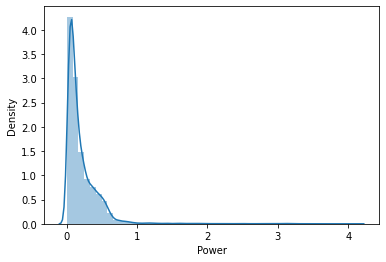

In [4]:
import seaborn as sns
sns.distplot(dataset['Power'])

(25391, 1, 8) (25391,) (336, 1, 8) (336,)
(25727, 9)
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.024459        0.0   0.000000   0.433333   0.545455   0.673469   
2       0.033558        0.0   0.021277   0.433333   0.545455   0.673469   
3       0.020937        0.0   0.042553   0.433333   0.545455   0.673469   
4       0.030232        0.0   0.063830   0.433333   0.545455   0.667639   
5       0.024557        0.0   0.085106   0.433333   0.545455   0.661808   
...          ...        ...        ...        ...        ...        ...   
25723   0.075042        1.0   0.893617   1.000000   1.000000   0.489796   
25724   0.071617        1.0   0.914894   1.000000   1.000000   0.491254   
25725   0.063888        1.0   0.936170   1.000000   1.000000   0.492711   
25726   0.069856        1.0   0.957447   1.000000   1.000000   0.492711   
25727   0.055278        1.0   0.978723   1.000000   1.000000   0.492711   

       var7(t-1)  var8(t-1)   var1(t)  
1     

556/556 [==============================] - 1s 3ms/step - loss: 0.0366 - mape: 83132.6679 - val_loss: 0.0305 - val_mape: 3461.4324
Epoch 49/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0362 - mape: 65544.4200 - val_loss: 0.0309 - val_mape: 3415.7812
Epoch 50/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0373 - mape: 88305.1109 - val_loss: 0.0306 - val_mape: 3408.9736
Epoch 51/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0376 - mape: 76881.9247 - val_loss: 0.0305 - val_mape: 3304.5161
Epoch 52/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0379 - mape: 77117.5741 - val_loss: 0.0305 - val_mape: 3463.9666
Epoch 53/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0371 - mape: 65720.4918 - val_loss: 0.0304 - val_mape: 3454.4119
Epoch 54/100
556/556 [==============================] - 1s 3ms/step - loss: 0.0371 - mape: 80123.3862 - val_loss: 0.0304 - val_mape: 3394.0879
Epoch 55/100

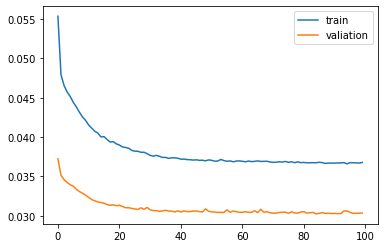

Test RMSE: 1.027
Test MAE: 0.438
Test MAPE: 0.329


In [18]:
from math import sqrt
from keras.callbacks import ReduceLROnPlateau



# split into train and test sets
values = reframed.values
n_train_hours = 529*48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(reframed.shape)
print(reframed)

callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='my_log_dir',
        histogram_freq=1,
        embeddings_freq=1,)
]

# design network
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Conv1D(filters = 48, kernel_size = 4, padding ='same', 
                            activation='relu', kernel_initializer ="glorot_uniform"))
model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model.add(layers.Conv1D(filters = 32, kernel_size = 4, padding ='same', 
                            activation='relu', kernel_initializer="glorot_uniform"))
model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model.add(layers.Conv1D(filters = 16, kernel_size = 4, padding ='same', 
                            activation='relu', kernel_initializer="glorot_uniform"))
model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model.add(layers.Dropout(0.3))
#model.add(layers.LSTM(50, return_sequences=True, activation="relu"))
#model.add(layers.LSTM(147, return_sequences=True, activation="relu"))
model.add(layers.LSTM(290, return_sequences=False, activation="relu"))
#model.add(layers.Dropout(0.5))
#model.add(Dense(32))
model.add(Dense(1))
#reduce_lr = ReduceLROnPlateau(monitor='mape', patience=10, mode='auto')
optimizer = keras.optimizers.Adam(lr=3e-5)
model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])
# model fit
history = model.fit(train_X, train_y, epochs=100, validation_split=0.3, 
                    shuffle=True, batch_size=32)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valiation')
pyplot.legend()
pyplot.show()




# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mean_absolute_error(inv_y, inv_yhat))
print('Test MAPE: %.3f' % mean_absolute_percentage_error(inv_y, inv_yhat))


In [25]:
'''
n_hidden=167, keneral_size=5, no droppout mape=0.693
n_hidden=167, keneral_size=5, drop1=0.4 mape=0.513
n_hidden=11, keneral_size=4, drop1=0.5, lr=0.003, mape=0.494'''


6112

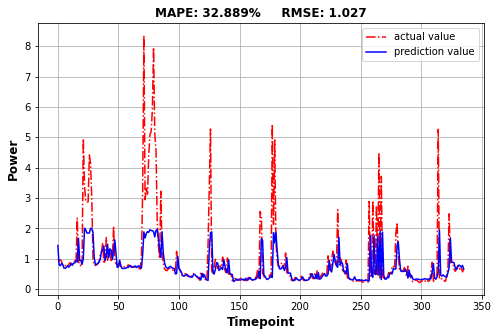

In [19]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mape = mape*100
font1 = {'weight':'bold',
        'size':12,}
pyplot.figure(figsize=(8, 5))
pyplot.plot(range(len(inv_y)), inv_y, ls='-.', c='red', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, ls='-', c='blue', label='prediction value')
pyplot.title('MAPE: %.3f%%' % mape + '     ' + 'RMSE: %.3f' % rmse, font1)
pyplot.xlabel('Timepoint', font1)
pyplot.ylabel('Power', font1)
pyplot.grid(True)
pyplot.legend()
pyplot.savefig('CNN-LSTM_line_1656')
pyplot.show()

In [ ]:
1580 1656